![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de popularidad en canción

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de popularidad en canción".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/competitions/miad-2025-12-prediccion-popularidad-en-cancion).

## Datos para la predicción de popularidad en cancion

En este proyecto se usará el conjunto de datos de datos de popularidad en canciones, donde cada observación representa una canción y se tienen variables como: duración de la canción, acusticidad y tempo, entre otras. El objetivo es predecir qué tan popular es la canción. Para más detalles puede visitar el siguiente enlace: [datos](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [37]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
# Importación librerías
import pandas as pd
import numpy as np

In [39]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2025/main/datasets/dataTrain_Spotify.csv')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2025/main/datasets/dataTest_Spotify.csv', index_col=0)

## Analisis preliminar de datos (EDA)

#### Contexto del problema

Se quiere crear un sistema de recomendacion basado en las preferencias del ususario. 

Se quiere clasificar las canciones en base a caracteristicas de audio y generos disponibles.

#### Variables

**track_id**: The Spotify ID for the track

**artists**: The artists' names who performed the track. If there is more than one artist, they are separated by a ;

**album_name**: The album name in which the track appears

**track_name**: Name of the track

**popularity**: The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.

**duration_ms**: The track length in milliseconds

**explicit**: Whether or not the track has explicit lyrics (true = yes it does; false = no it does not OR unknown)

**danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable

**energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale

**key**: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1

**loudness**: The overall loudness of a track in decibels (dB)

**mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0

**speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks

**acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic

**instrumentalness**: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content

**liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live

**valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)

**tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration

**time_signature**: An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of 3/4, to 7/4.

**track_genre**: The genre in which the track belongs

In [40]:
dataTraining.drop(columns=['Unnamed: 0'], inplace=True)

In [41]:
dataTraining.dtypes

track_id             object
artists              object
album_name           object
track_name           object
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
popularity            int64
dtype: object

In [42]:
# Memoria antes de optimización
mem_before = dataTraining.memory_usage(deep=True).sum() / 1024**2  # en MB

# Optimizar tipos de datos
for col in dataTraining.columns:
    col_type = dataTraining[col].dtype

    if col_type == 'float64':
        dataTraining[col] = dataTraining[col].astype('float32')
    elif col_type == 'int64':
        dataTraining[col] = dataTraining[col].astype('int32')
    elif col_type == 'bool':
        dataTraining[col] = dataTraining[col].astype('int8')  # más compacto
    elif col_type == 'object':
        num_unique_values = dataTraining[col].nunique()
        num_total_values = len(dataTraining[col])
        if num_unique_values / num_total_values < 0.5:
            dataTraining[col] = dataTraining[col].astype('category')

# Memoria después de optimización
mem_after = dataTraining.memory_usage(deep=True).sum() / 1024**2  # en MB

print(f'Memoria antes: {mem_before:.2f} MB')
print(f'Memoria después: {mem_after:.2f} MB')
print(f'Reducción: {100 * (mem_before - mem_after) / mem_before:.2f}%')

Memoria antes: 34.15 MB
Memoria después: 22.43 MB
Reducción: 34.33%


In [43]:
dataTraining.dtypes

track_id              object
artists             category
album_name          category
track_name            object
duration_ms            int32
explicit                int8
danceability         float32
energy               float32
key                    int32
loudness             float32
mode                   int32
speechiness          float32
acousticness         float32
instrumentalness     float32
liveness             float32
valence              float32
tempo                float32
time_signature         int32
track_genre         category
popularity             int32
dtype: object

In [44]:
# Revisar valores faltantes
missing = dataTraining.isnull().sum()
print("Valores nulos por columna:\n", missing[missing > 0])

# Revisar columnas con un solo valor
constant_columns = [col for col in dataTraining.columns if dataTraining[col].nunique() == 1]
print("Columnas constantes (sin variabilidad):", constant_columns)

# Eliminar columnas constantes
dataTraining.drop(columns=constant_columns, inplace=True)


Valores nulos por columna:
 Series([], dtype: int64)
Columnas constantes (sin variabilidad): []


In [45]:
# Revisar tipos de datos y ajustarlos si es necesario
for col in dataTraining.columns:
    if dataTraining[col].dtype == 'object':
        try:
            dataTraining[col] = pd.to_datetime(dataTraining[col])
            print(f"{col} convertido a datetime")
        except:
            pass


In [46]:
# Verificación general
print("Revisión final de nulos:", dataTraining.isnull().sum().sum())
print("Tamaño final del dataset:", dataTraining.shape)


Revisión final de nulos: 0
Tamaño final del dataset: (79800, 20)


In [47]:
# Visualización datos de entrenamiento
dataTraining.describe()

,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity
count,7.980000e+04,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000
mean,2.279022e+05,0.085689,0.567318,0.641529,5.307043,-8.263741,0.637732,0.084750,0.314979,0.157319,0.213313,0.474267,122.076569,3.902556,33.265301
std,1.050599e+05,0.279906,0.173110,0.251441,3.562186,5.035504,0.480659,0.105657,0.332512,0.310792,0.190075,0.259010,29.941936,0.434284,22.330871
min,1.338600e+04,0.000000,0.000000,0.000019,0.000000,-49.306999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.744360e+05,0.000000,0.456000,0.472000,2.000000,-10.006000,0.000000,0.035900,0.017000,0.000000,0.097900,0.261000,99.081251,4.000000,17.000000
50%,2.128130e+05,0.000000,0.581000,0.685000,5.000000,-7.012000,1.000000,0.049000,0.169000,0.000041,0.132000,0.464000,122.009003,4.000000,35.000000
75%,2.614260e+05,0.000000,0.695000,0.854000,8.000000,-5.000000,1.000000,0.084500,0.598000,0.050500,0.273000,0.684000,140.054001,4.000000,50.000000
max,5.237295e+06,1.000000,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,222.604996,5.000000,100.000000


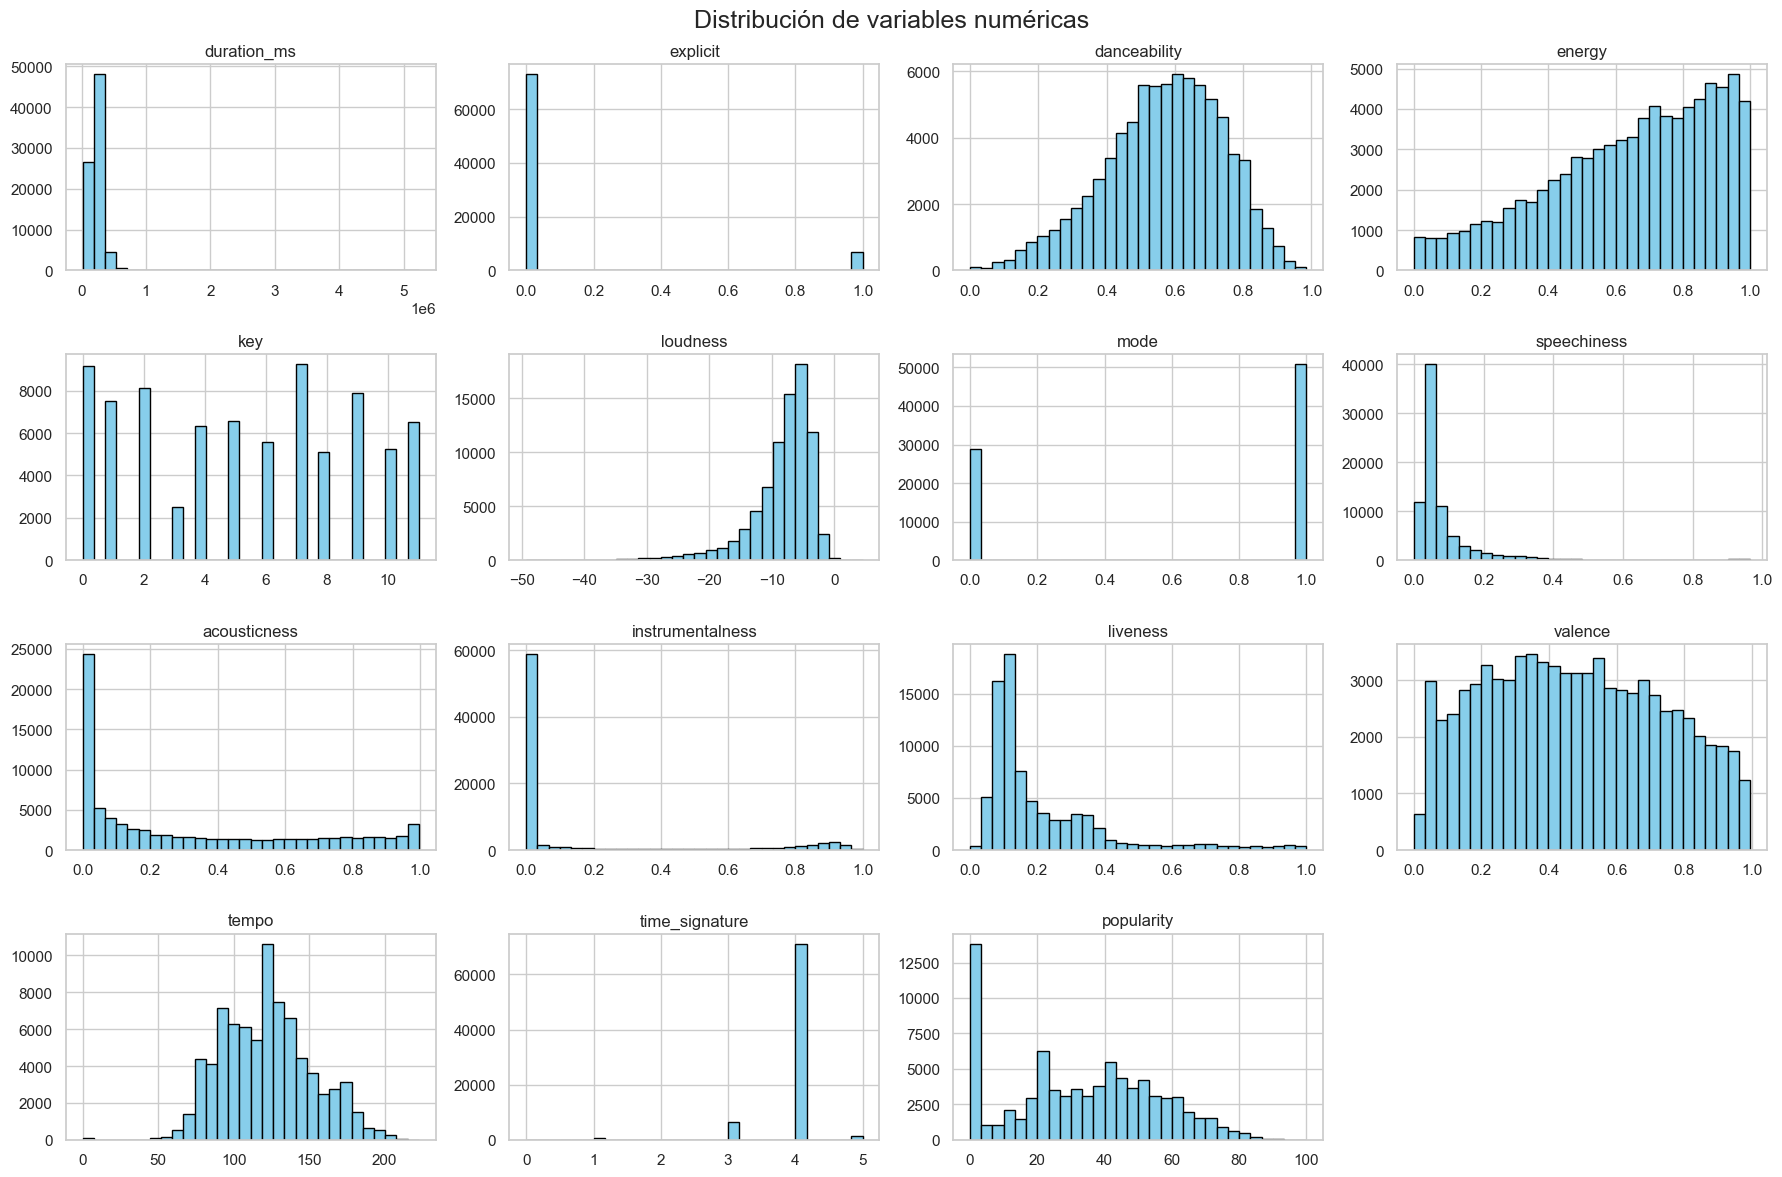

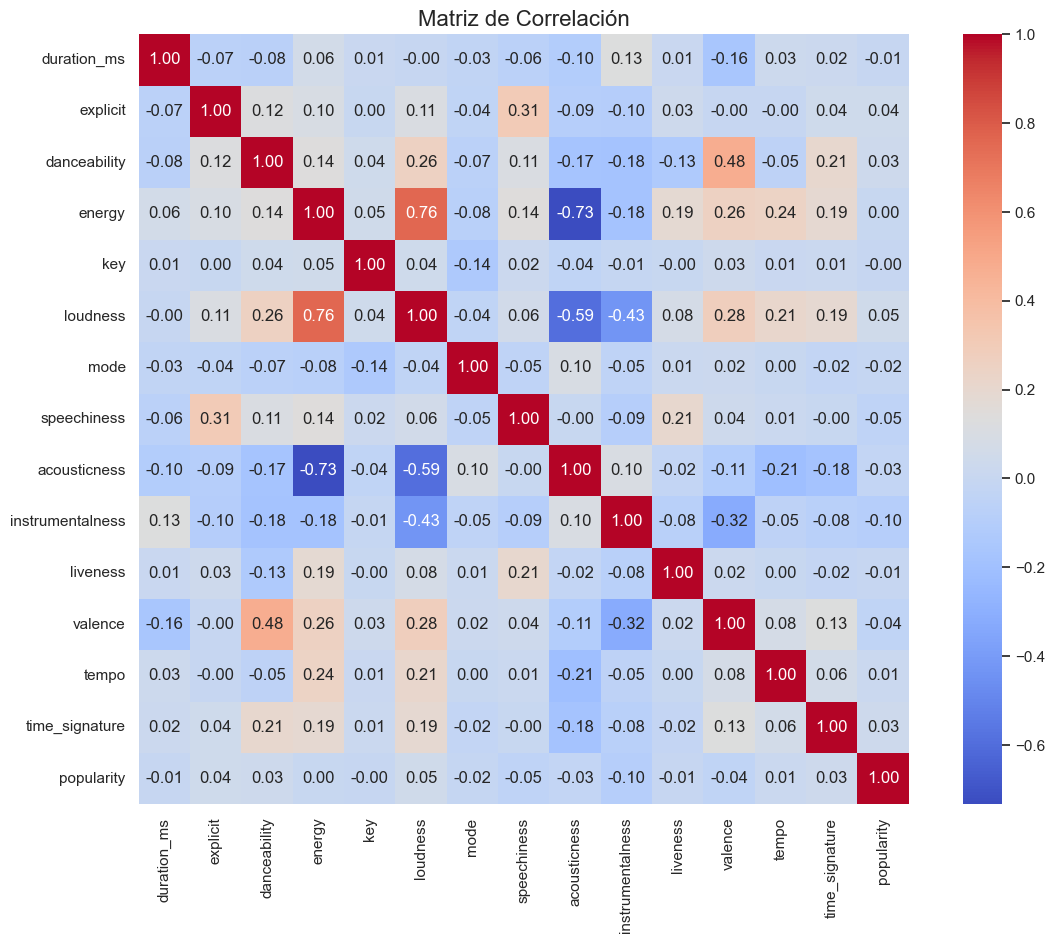

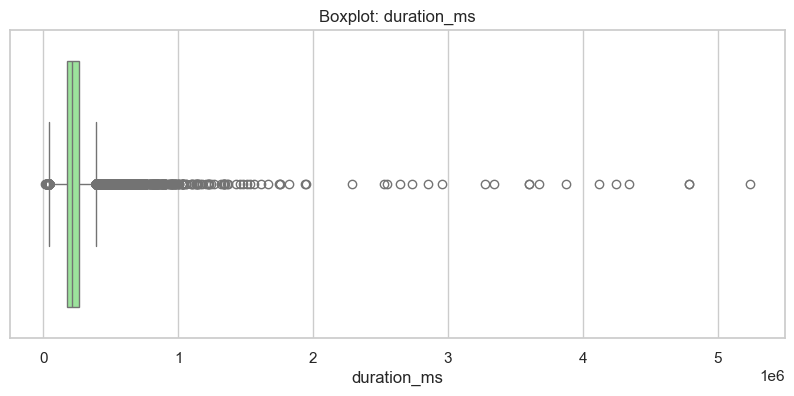

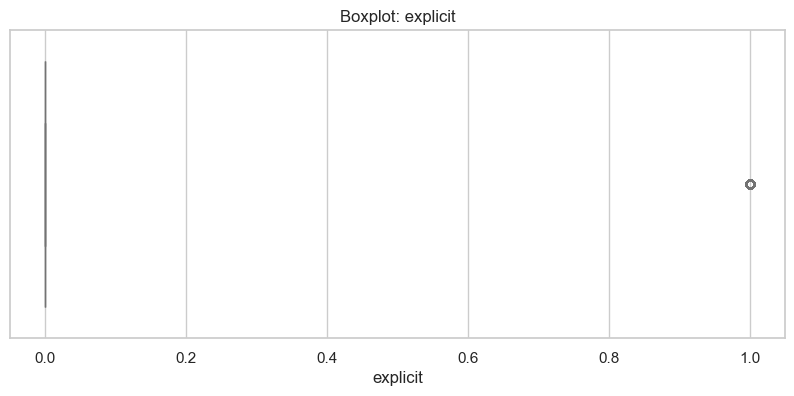

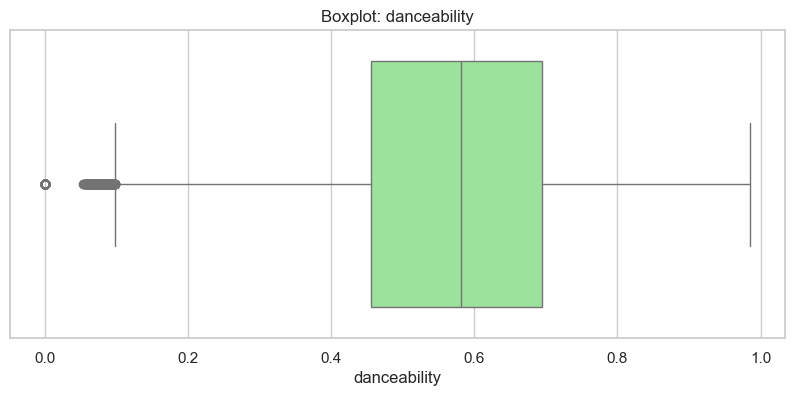

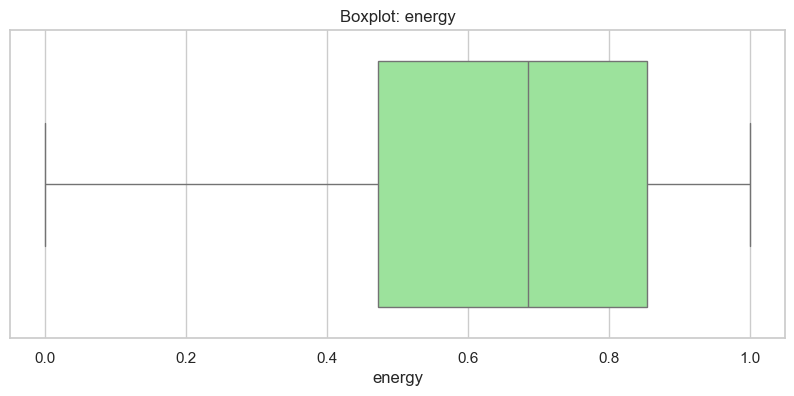

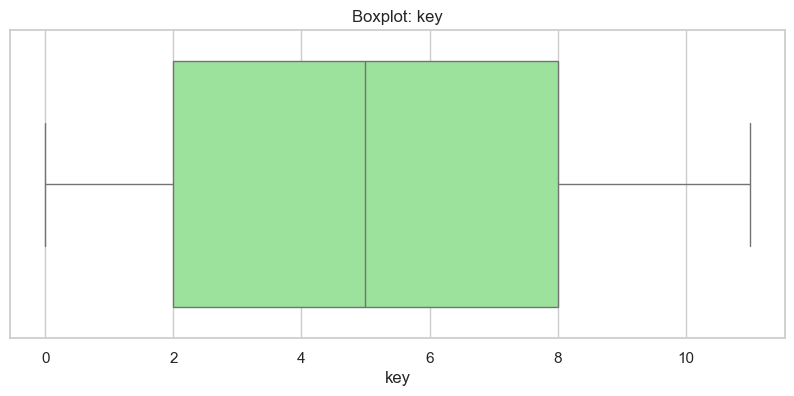

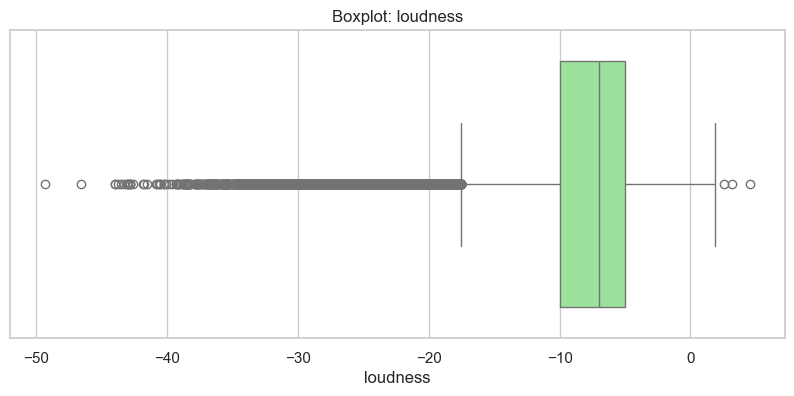

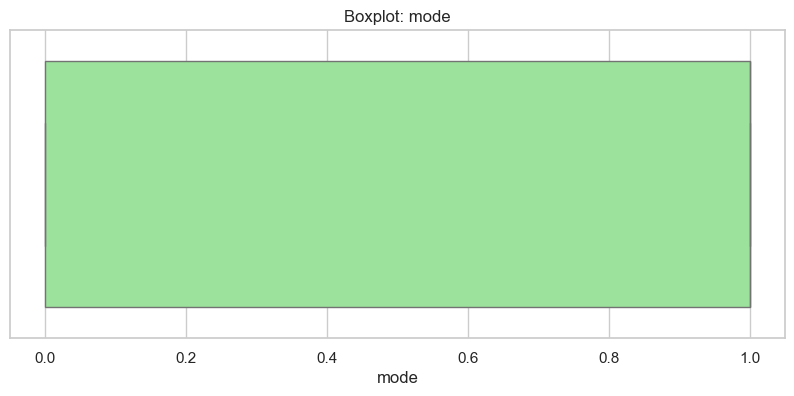

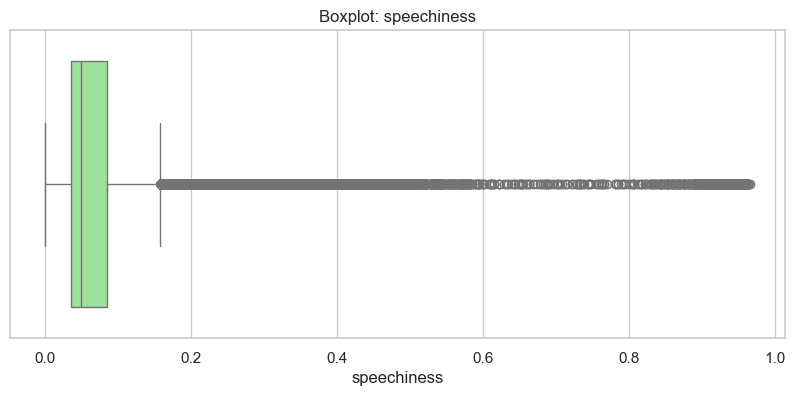

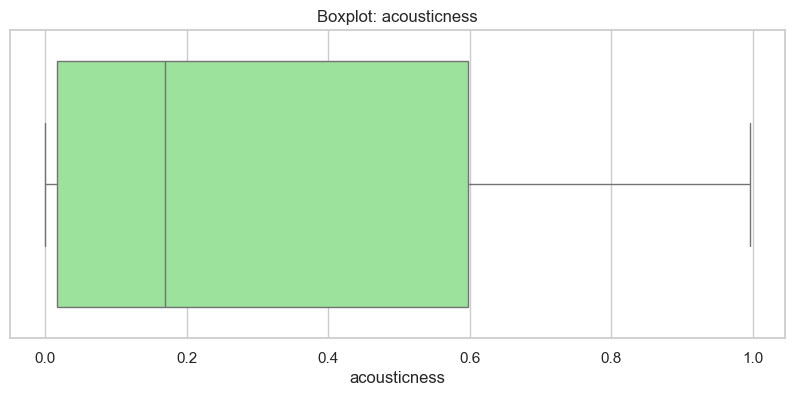

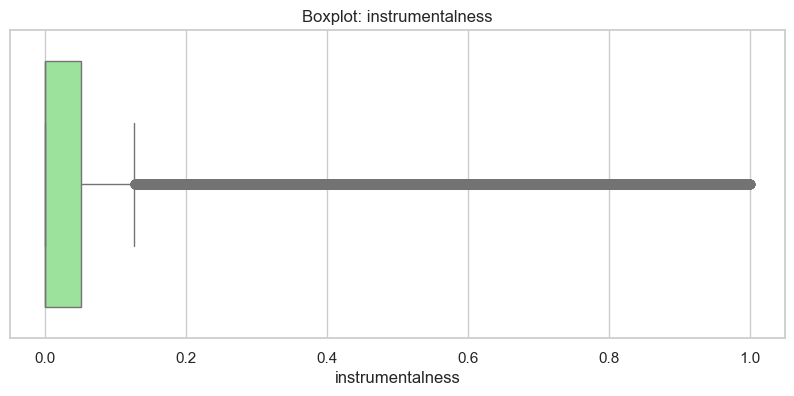

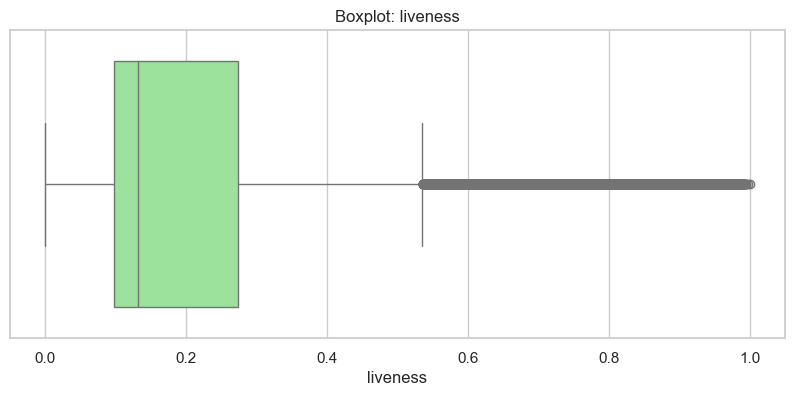

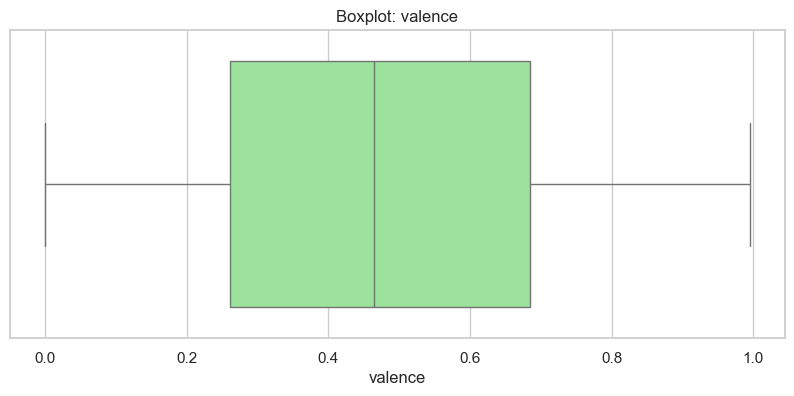

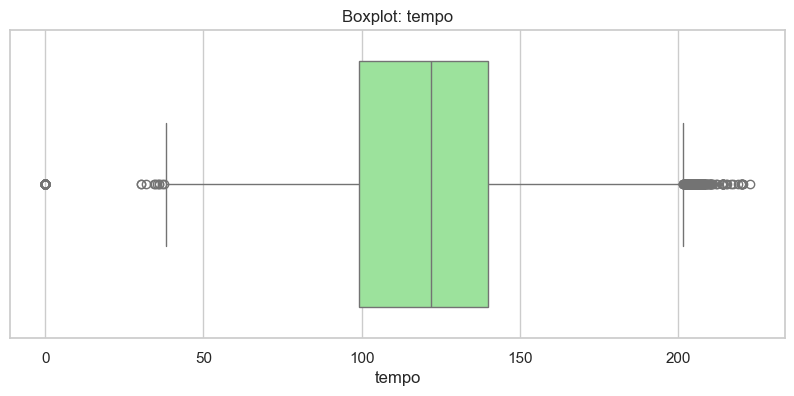

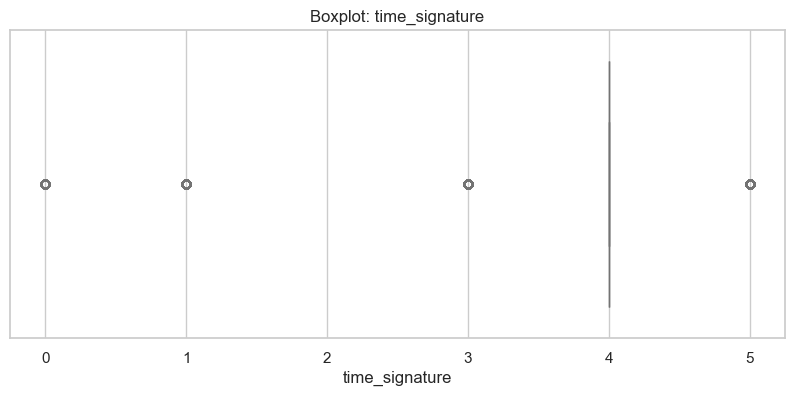

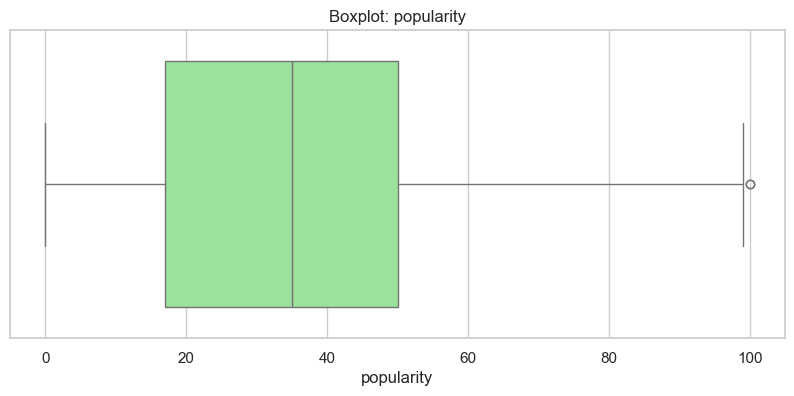

In [48]:
# Librerías necesarias
import matplotlib.pyplot as plt
import seaborn as sns

# Estilos de los gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# --- 1. Histograma de variables numéricas ---
dataTraining.select_dtypes(include=np.number).hist(bins=30, figsize=(18, 12), color='skyblue', edgecolor='black')
plt.suptitle("Distribución de variables numéricas", fontsize=18)
plt.tight_layout()
plt.show()

# --- 2. Mapa de calor de correlación ---
plt.figure(figsize=(14, 10))
corr = dataTraining.select_dtypes(include=np.number).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de Correlación", fontsize=16)
plt.show()

# --- 3. Boxplots para identificar outliers ---
for col in dataTraining.select_dtypes(include=np.number).columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=dataTraining[col], color='lightgreen')
    plt.title(f"Boxplot: {col}")
    plt.show()


In [49]:
# --- Variables categóricas ---
cat_cols = dataTraining.select_dtypes(include=['object','category']).columns.tolist()

# Visualizar la cantidad de valores únicos por variable categórica
print("Valores únicos por variable categórica:")
for col in cat_cols:
    print(f"{col}: {dataTraining[col].nunique()} valores únicos")

# --- 1. Distribución de frecuencia de las principales categorías ---
for col in cat_cols:
    if dataTraining[col].nunique() <= 50:  # Limita el análisis a columnas con un número manejable de categorías
        plt.figure(figsize=(10, 5))
        dataTraining[col].value_counts().head(20).plot(kind='bar', color='cornflowerblue')
        plt.title(f"Top 20 valores de {col}")
        plt.ylabel("Frecuencia")
        plt.xlabel(col)
        plt.xticks(rotation=45)
        plt.show()

# --- 2. Popularidad promedio por categoría ---
for col in cat_cols:
    if 'popularity' in dataTraining.columns and dataTraining[col].nunique() <= 50:
        popularity_by_cat = dataTraining.groupby(col)['popularity'].mean().sort_values(ascending=False).head(20)
        plt.figure(figsize=(10, 5))
        sns.barplot(x=popularity_by_cat.values, y=popularity_by_cat.index, palette="viridis")
        plt.title(f"Popularidad promedio por {col} (Top 20)")
        plt.xlabel("Popularidad Promedio")
        plt.ylabel(col)
        plt.show()


Valores únicos por variable categórica:
track_id: 66720 valores únicos
artists: 25775 valores únicos
album_name: 37315 valores únicos
track_name: 55767 valores únicos
track_genre: 114 valores únicos


In [50]:
# Agrupar por 'track_genre' y calcular las medias de las columnas seleccionadas
perfil_generos = dataTraining.groupby('track_genre')[dataTraining.select_dtypes(include=np.number).columns].mean().round(2).sort_values('popularity', ascending=False)

# Mostrar el perfil
print(perfil_generos)

                duration_ms  explicit  danceability  energy   key  loudness  \
track_genre                                                                   
pop-film          279722.57      0.00          0.59    0.60  5.23     -7.89   
k-pop             254177.60      0.05          0.65    0.68  5.46     -6.43   
chill             169200.60      0.17          0.67    0.42  5.33    -10.52   
sad               154555.27      0.45          0.69    0.47  5.44    -10.20   
grunge            236282.95      0.07          0.45    0.80  5.29     -5.63   
...                     ...       ...           ...     ...   ...       ...   
chicago-house     357606.00      0.02          0.77    0.73  5.86     -9.23   
detroit-techno    370444.11      0.01          0.72    0.72  5.68    -11.01   
latin             213044.33      0.12          0.72    0.72  5.47     -5.28   
romance           202043.54      0.00          0.43    0.29  5.19    -13.21   
iranian           316496.70      0.08          0.30 

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [52]:
df = dataTraining.copy()
X = df.drop(columns=['popularity']) 
y = df['popularity']

categorical_cols = df.select_dtypes(include=['object','category']).columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [53]:

import category_encoders as ce

In [54]:
encoder = ce.TargetEncoder(cols=categorical_cols)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

In [55]:
from sklearn.feature_selection import RFE

In [56]:
# Aplicar RFE
estimator = DecisionTreeRegressor(max_depth=21, min_samples_leaf=4, random_state=0)
rfe = RFE(estimator=estimator, n_features_to_select=10)
rfe.fit(X_train_encoded, y_train)

# Extraer características seleccionadas
selected_features = X_train_encoded.columns[rfe.support_]
ranking = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Rank': rfe.ranking_,
    'Selected': rfe.support_
}).sort_values(by='Rank')

selected_features, ranking

(Index(['track_id', 'album_name', 'track_name', 'danceability', 'key',
        'loudness', 'acousticness', 'instrumentalness', 'tempo', 'track_genre'],
       dtype='object'),
              Feature  Rank  Selected
 0           track_id     1      True
 2         album_name     1      True
 3         track_name     1      True
 6       danceability     1      True
 12      acousticness     1      True
 13  instrumentalness     1      True
 9           loudness     1      True
 8                key     1      True
 18       track_genre     1      True
 16             tempo     1      True
 11       speechiness     2     False
 7             energy     3     False
 15           valence     4     False
 4        duration_ms     5     False
 1            artists     6     False
 14          liveness     7     False
 17    time_signature     8     False
 10              mode     9     False
 5           explicit    10     False)

In [57]:
X_train_encoded.drop(columns=['speechiness', 'energy', 'valence', 'duration_ms', 'artists', 'liveness', 'time_signature', 'mode', 'explicit'], inplace=True)
X_test_encoded.drop(columns=['speechiness', 'energy', 'valence', 'duration_ms', 'artists', 'liveness', 'time_signature', 'mode', 'explicit'], inplace=True)

In [ ]:
# base_estimator = DecisionTreeRegressor(max_depth=maxdepth, min_samples_leaf=3, random_state=0)

# model = AdaBoostRegressor(estimator=base_estimator, n_estimators=nestimator, learning_rate=learningrate, loss='linear', random_state=0)

# model.fit(X_train_encoded, y_train)

# y_pred_lineal = model.predict(X_test_encoded)

In [58]:
from sklearn.model_selection import GridSearchCV

In [66]:
# Corrección del parámetro: usar estimator en lugar de base_estimator
base_estimator = DecisionTreeRegressor()
adaboost = AdaBoostRegressor(estimator=base_estimator, random_state=0)

# Definimos los parámetros del estimator para explorar
param_grid = {
    'estimator__max_depth': [22,25,30],
    'estimator__min_samples_leaf': [3, 4],
    'n_estimators': [100],
    'learning_rate': [0.4, 0.5, 0.6]
}

# GridSearchCV para hacer tuning
grid_search = GridSearchCV(estimator=adaboost, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)

# Ajustar modelo
grid_search.fit(X_train_encoded, y_train)

# Resultados
best_params = grid_search.best_params_
best_score = -grid_search.best_score_
cv_results = pd.DataFrame(grid_search.cv_results_)

best_params, best_score, cv_results[['param_estimator__max_depth', 'param_estimator__min_samples_leaf', 'mean_test_score']]


Fitting 5 folds for each of 18 candidates, totalling 90 fits


({'estimator__max_depth': 22,
  'estimator__min_samples_leaf': 3,
  'learning_rate': 0.5,
  'n_estimators': 100},
 np.float64(0.12705993212424702),
     param_estimator__max_depth  param_estimator__min_samples_leaf  \
 0                           22                                  3   
 1                           22                                  3   
 2                           22                                  3   
 3                           22                                  4   
 4                           22                                  4   
 5                           22                                  4   
 6                           25                                  3   
 7                           25                                  3   
 8                           25                                  3   
 9                           25                                  4   
 10                          25                                  4   
 11         

Mean Squared Error (MSE): 328.7829
Root Mean Squared Error (RMSE): 18.1324
R-squared (R²): 0.3422


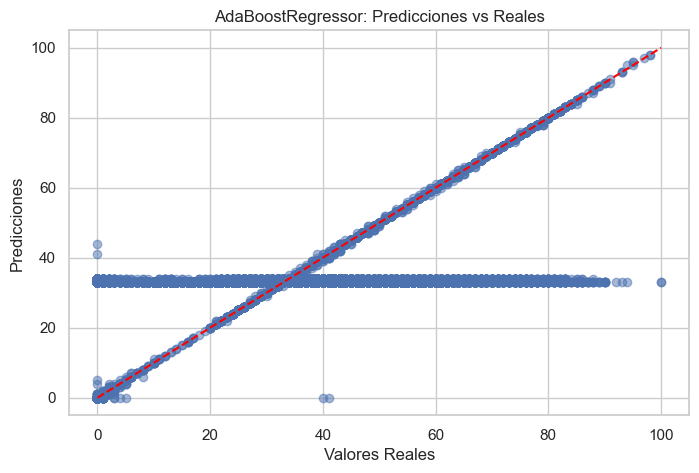

In [67]:
base_estimator = DecisionTreeRegressor(max_depth=22, min_samples_leaf=3, random_state=0)

model = AdaBoostRegressor(estimator=base_estimator, n_estimators=100, learning_rate=0.5, random_state=0)
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("AdaBoostRegressor: Predicciones vs Reales")
plt.grid(True)
plt.show()

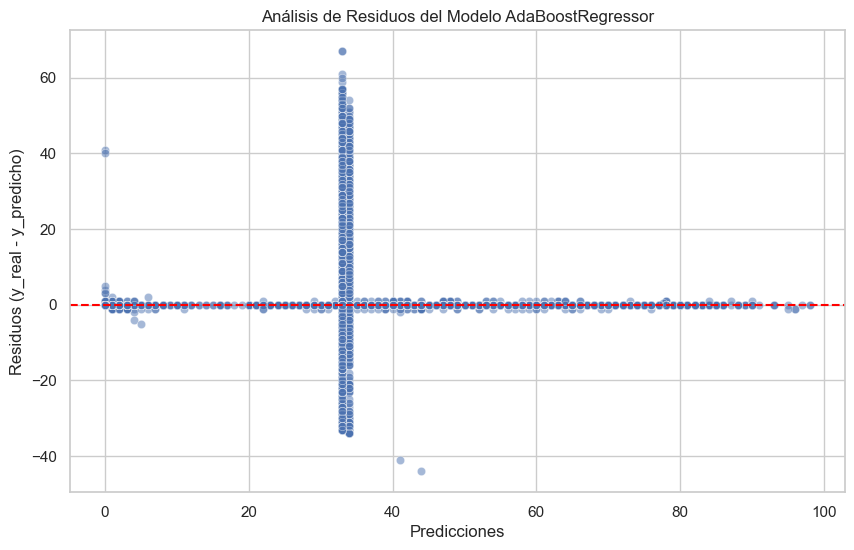

In [68]:
# Cálculo de los residuos
residuos = y_test - y_pred

# Configuración del estilo gráfico
sns.set(style="whitegrid")

# Gráfico de residuos vs predicciones
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuos, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicciones")
plt.ylabel("Residuos (y_real - y_predicho)")
plt.title("Análisis de Residuos del Modelo AdaBoostRegressor")
plt.show()

In [148]:
# Crear segmentos basados en la popularidad original (desde df original)
df['pop_segment'] = pd.cut(df['tempo'], bins=[0, 50, 70, 180, 200, 240], labels=['Bajo', 'Medio bajo' , 'Medio', 'Medio alto', 'Alto'])

# Añadir la columna segmentada a los conjuntos X_train y X_test según sus índices
X_train_encoded['pop_segment'] = df.loc[X_train_encoded.index, 'pop_segment']
X_test_encoded['pop_segment'] = df.loc[X_test_encoded.index, 'pop_segment']

# Entrenar un modelo por grupo
modelos_segmentados = {}

for seg in X_train_encoded['pop_segment'].dropna().unique():
    X_seg = X_train_encoded[X_train_encoded['pop_segment'] == seg].drop(columns='pop_segment')
    idx = X_seg.index
    y_seg = y_train.loc[idx]

    base_estimator = DecisionTreeRegressor(max_depth=22, min_samples_leaf=3, random_state=0)
    modelo = AdaBoostRegressor(estimator=base_estimator, n_estimators=100, learning_rate=0.5, random_state=0)
    modelo.fit(X_seg, y_seg)

    modelos_segmentados[seg] = modelo


In [149]:
# Crear DataFrame para almacenar las predicciones por segmento
predicciones_segmentadas = pd.DataFrame(index=X_test_encoded.index)

# Iterar sobre cada segmento y realizar predicciones
for seg, modelo in modelos_segmentados.items():
    # Filtrar los datos del segmento
    X_seg_test = X_test_encoded[X_test_encoded['pop_segment'] == seg].drop(columns='pop_segment')

    # Realizar predicción
    y_pred_seg = modelo.predict(X_seg_test)

    # Almacenar predicción
    predicciones_segmentadas.loc[X_seg_test.index, 'y_pred'] = y_pred_seg
    predicciones_segmentadas.loc[X_seg_test.index, 'segmento'] = seg

# Añadir valores reales para comparación
predicciones_segmentadas['y_real'] = y_test

# Ordenar por predicción
predicciones_segmentadas = predicciones_segmentadas.sort_values(by='y_pred', ascending=False)

# Mostrar tabla final
predicciones_segmentadas.head()


,y_pred,segmento,y_real
17924,98.0,Medio,98
71798,98.0,Medio,98
60016,97.0,Medio,97
61004,96.0,Medio,95
46003,96.0,Medio,95


In [151]:
# Diccionario para guardar las métricas por segmento
metricas_segmentadas = {}

for seg in predicciones_segmentadas['segmento'].dropna().unique():
    # Seleccionar predicciones y reales del segmento
    print(f"Segmento: {seg}")
    
    # Filtrar datos del segmento
    datos_seg = predicciones_segmentadas[predicciones_segmentadas['segmento'] == seg]
    y_real = datos_seg['y_real']
    y_pred = datos_seg['y_pred']

    # Calcular métricas
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_real, y_pred)

    # Guardar
    metricas_segmentadas[seg] = {
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

# Convertir a DataFrame para mostrar
df_metricas = pd.DataFrame(metricas_segmentadas).T
df_metricas.index.name = 'Segmento'
df_metricas.reset_index(inplace=True)
df_metricas


Segmento: Medio
Segmento: Alto
Segmento: Medio alto
Segmento: Medio bajo
Segmento: Bajo


,Segmento,MSE,RMSE,R2
0,Medio,329.335210,18.147595,0.343207
1,Alto,326.668162,18.073964,0.385673
2,Medio alto,270.879855,16.458428,0.415033
3,Medio bajo,401.505334,20.037598,0.120215
4,Bajo,165.059947,12.847566,0.366293


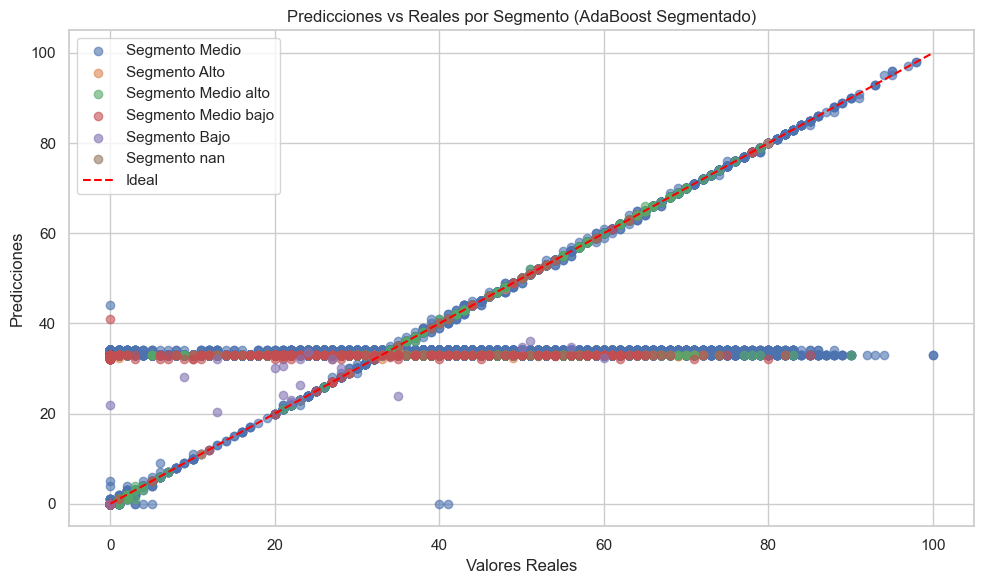

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar cada segmento con diferente color
for seg in predicciones_segmentadas['segmento'].unique():
    datos_seg = predicciones_segmentadas[predicciones_segmentadas['segmento'] == seg]
    plt.scatter(
        datos_seg['y_real'], 
        datos_seg['y_pred'], 
        alpha=0.6, 
        label=f"Segmento {seg}"
    )

# Línea de identidad
min_val = predicciones_segmentadas[['y_real', 'y_pred']].min().min()
max_val = predicciones_segmentadas[['y_real', 'y_pred']].max().max()
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal')

# Etiquetas y estilo
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Reales por Segmento (AdaBoost Segmentado)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [153]:
predicciones_rango = predicciones_segmentadas[(predicciones_segmentadas['y_pred'] >= 32) & (predicciones_segmentadas['y_pred'] <= 34)]

# Contar la cantidad de valores por segmento
conteo_por_segmento = predicciones_rango['segmento'].value_counts().reset_index()
conteo_por_segmento.columns = ['Segmento', 'Cantidad']

# Mostrar la tabla
print(conteo_por_segmento)

     Segmento  Cantidad
0       Medio     19710
1  Medio alto       492
2  Medio bajo       365
3        Alto       113
4        Bajo         5


In [63]:
# Crear DataFrame con resultados
df_resultados = X_test_encoded.copy()  # copia las features

df_resultados['Prediccion'] = y_pred
df_resultados['Real'] = y_test.values

df_resultados_ordenado = df_resultados.sort_values(by='Prediccion', ascending=False)

# Mostrar los primeros registros ordenados
df_resultados_ordenado.to_csv('resultados_ordenados.csv', index=False)

In [65]:
# Guardar predicciones en formato exigido en la competencia de kaggle
X_testing_encoded = encoder.transform(dataTesting)
X_testing_encoded.drop(columns=['speechiness', 'energy', 'valence', 'duration_ms', 'artists', 'liveness', 'time_signature', 'mode', 'explicit'], inplace=True)  # eliminar track_id del conjunto de test
y_pred = model.predict(X_testing_encoded)  # predicción sobre el conjunto de test

# Convertir y_pred a DataFrame
y_pred_df = pd.DataFrame(y_pred, index=dataTesting.index, columns=['Popularity'])

# Guardar en CSV
y_pred_df.to_csv('test_submission_file.csv', index_label='ID')
y_pred_df.head()

,Popularity
0,34.0
1,33.0
2,33.0
3,0.0
4,33.0


In [97]:
# Crear columna de segmento en X_testing_encoded
X_testing_encoded['pop_segment'] = pd.cut(
    X_testing_encoded['danceability'], 
    bins=[0, 20, 40, 60, 80, 100], 
    labels=['Bajo', 'Medio bajo' , 'Medio', 'Medio alto', 'Alto']
    )


# Inicializar lista para guardar resultados
predicciones_finales = []

# Realizar predicciones por segmento
for seg in X_testing_encoded['pop_segment'].unique():
    X_seg = X_testing_encoded[X_testing_encoded['pop_segment'] == seg].copy()
    modelo = modelos_segmentados.get(seg)

    if modelo:
        y_pred_seg = modelo.predict(X_seg.drop(columns=['pop_segment']))
        predicciones_finales.append(
            pd.DataFrame({'ID': X_seg.index, 'Popularity': y_pred_seg})
        )

# Unir los resultados y ordenar por ID
y_pred_df = pd.concat(predicciones_finales).sort_values('ID')
y_pred_df.set_index('ID', inplace=True)

# Guardar en CSV
y_pred_df.to_csv('test_submission_file.csv', index_label='ID')

# Mostrar las primeras filas
y_pred_df.head()


,Popularity
ID,
0,33.0
1,33.0
2,33.0
3,0.0
4,33.0
